# K-means

Kmeans algorithm is an iterative algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to only one group.

It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible.

It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. The less variation we have within clusters, the more homogeneous (similar) the data points are within the same cluster.

The way kmeans algorithm works is as follows:
1) Specify number of clusters K.<br>
2) Initialize centroids by first shuffling the dataset and then randomly selecting K data points for the centroids without replacement.<br>
3) Keep iterating until there is no change to the centroids. i.e assignment of data points to clusters isn’t changing.<br>
4) Compute the sum of the squared distance between data points and all centroids.<br>
5) Assign each data point to the closest cluster (centroid).<br>
6) Compute the centroids for the clusters by taking the average of the all data points that belong to each cluster.<br>

The approach kmeans follows to solve the problem is called Expectation-Maximization. The E-step is assigning the data points to the closest cluster. The M-step is computing the centroid of each cluster. 

In [1]:
import numpy as np

from scipy.stats import mode

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Implementation of Kmean from scratch

In [2]:
def class_freq(labels):
    '''
    return count per class/label
    labels: list of classes per instance
    '''
    oh_labels = onehot(labels)
    freq = np.sum(oh_labels, axis=0)
    return freq

def onehot(labels):
    '''
    create one hot encoding of labels
    labels: list of classes per instance
    '''
    num_classes = labels.max() + 1
    size = labels.shape[0]
    one_hot = np.zeros((size, num_classes))
    one_hot[np.arange(size), labels] = 1
    return one_hot

class kMeans:
    
    def __init__(self, k):
        '''
        k: amount of clusters we assume exist in data
        '''
        self.k = k
        
    def fit(self, X, max_runs=25):
        '''
        compute cluster
        X: matrix of coodinates for data points
        max_runs: maximum amout of iterations to do if clusters do not converge before 
        '''
        # Start centroids randomly from data
        old_centroids = np.array([0])
        centroids = X[np.random.choice(X.shape[0], size=self.k, replace=False)]
        i = 0
        while(~np.array_equal(centroids, old_centroids) & i < max_runs):
            i += 1
            # Create distance matrix for each point form centroids
            broadcast_mat = np.expand_dims(X , axis=1) - centroids
            dist_mat = np.linalg.norm(broadcast_mat, axis=-1)
            # Define which cluster each point belongs to
            clusters = dist_mat.argmin(axis=1)
            # second update the cluster center
            old_centroids = centroids
            centroids = onehot(clusters).T @ X / np.expand_dims(class_freq(clusters), axis=1)

        self.centroids = centroids

    def predict(self, X):
        '''
        predict class/label of each given data point
        X: matrix of coodinates for data points
        '''
        # Get distance to all centroids 
        broadcast_mat = np.expand_dims(X , axis=1) - self.centroids
        dist_mat = np.linalg.norm(broadcast_mat, axis=-1)
        # return label of centroid with minimum distance
        return  dist_mat.argmin(axis=1)
    
    def fit_predict(self, X):
        '''
        compute clusters & predict class/label of each given data point
        X: matrix of coodinates for data points
        '''
        self.fit(X)
        return self.predict(X)
    
    def get_params(self):
        '''
        get params of model
        '''
        return self.centroids

        

### Read blood test results as an EMR from file

In [3]:
# Open the file
xlsx = pd.ExcelFile('./datasets/EMR-Blood.xlsx')

# Get the first sheet as an object
sheet1 = xlsx.parse(0)

# Set the Key column as the index
sheet1.set_index("Key", inplace=True)

# Retrieve the K, WBC and Hgb column values from the dataset to cluster
variables1 = ["K","WBC","Hgb"]
EMR3d1 = sheet1.loc[:, variables1].values

### Run the K-Means algorithm, assuming the correct number of clusters is 5

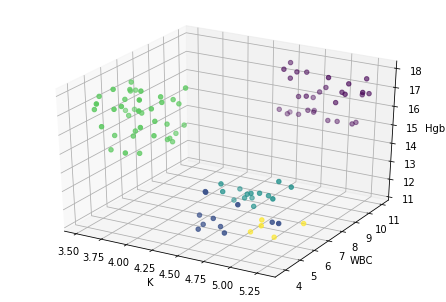

In [4]:
def make_chart (chart_data, y_pred, labels):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c=y_pred)

kmeans = kMeans(5)
y_pred_KMeans1 = kmeans.fit_predict(EMR3d1)
make_chart(EMR3d1, y_pred_KMeans1, variables1)

## Choosing K

We as humans can easily spot patterns and thus for us there arte clearly 3 clusters above, however, machines have a harder time identifying that. In the above implementation, K-Means was given the value of 5 as K.
We will not try to develop a generic mechanism for finding the most reasonable number of clusters.

In [5]:
def mse(X, kmeans):
    '''
    returns mse of given clustering solution
    X: matrix of coodinates for data points
    kmeans: label/class given to each data point
    '''
    y = kmeans.predict(X)
    centroids = kmeans.get_params()
    return np.square(np.linalg.norm(((onehot(y) @ centroids) - X), axis=-1)).sum()/X.shape[0]
    

def get_k(X, kMeans, labels, error):
    '''
    in order to choose k we take the point with the largest change between the angle before and after. This usually defines the "elbow" of the graph. 
    X: matrix of coodinates for data points
    kmeans: label/class given to each data point
    '''
    k_list = [k for k in range(1,9)]
    mse_list = []
    for k in k_list:
        km = kMeans(k)
        km.fit(X)
        mse_list.append(error(X, km))
    plt.plot(k_list, mse_list)
    chosen_k = k_list[np.argmax(np.array([post/prev for post, prev in zip(mse_list[:-1], mse_list[1:])])) + 1]
    print(f'We choose k = {chosen_k}')
    # plot according to chosen k
    km = kMeans(chosen_k)
    y_pred = km.fit_predict(X)
    make_chart(X, y_pred, labels)


We choose k = 3


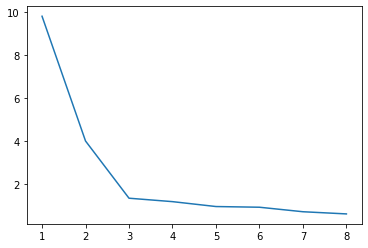

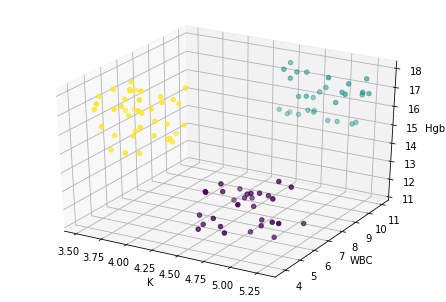

In [6]:
get_k(EMR3d1, kMeans, variables1, mse)

### Silhouette analysis

Here we use graphic visualization of the Silhouette score to support our above answer

In [7]:
# scikit-learn Sillhouette page used as a reference

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def plot_Silhouette(X, y, n_clusters):
    from sklearn.cluster import KMeans
    fig, ax1 = plt.subplots()
    fig.set_size_inches(9, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


We choose k = 3
For n_clusters = 3 The average silhouette_score is : 0.644343998493909


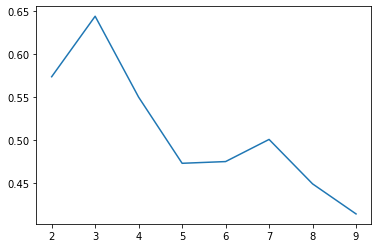

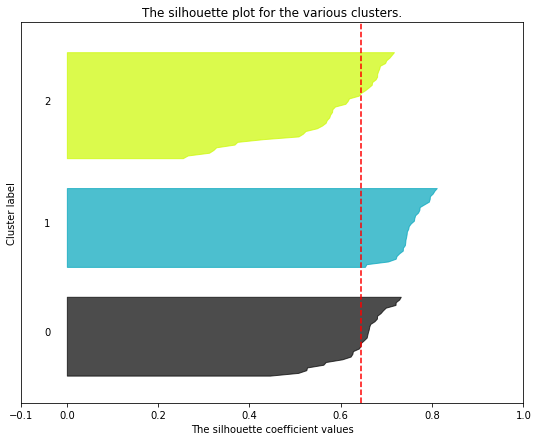

In [8]:
X = EMR3d1

k_list = [k for k in range(2,10)]
aws_list = []
for k in k_list:
    km = kMeans(k)
    y = km.fit_predict(X)
    aws_list.append(silhouette_score(X, y))
plt.plot(k_list, aws_list)
chosen_k = k_list[np.argmax(np.array(aws_list))]
print(f'We choose k = {chosen_k}')

km = kMeans(chosen_k)
y_pred = km.fit_predict(X)
plot_Silhouette(X, y_pred, chosen_k)